In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import sys
sys.path.append('../Utilities')
sys.path.append('../ControllersObject')
sys.path.append('../')

import LMPC
import SysModel
from trackInitialization import Map
import utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [21]:
trackname = 'oval'
trackMap = Map(trackname) 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

affine = False
dim0 = n+d+1 if affine else n+d
# mask = [A B d].T
sparse_mask = np.ones([n, dim0])
sparse_mask[0:3, 3:6] = 0
sparse_mask[0,6] = 0
sparse_mask[1:3,7] = 0
sparse_mask[3:,6:8] = 0
sparse_mask = sparse_mask.T

n_data = 1000

In [22]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    # NOTE:
    # vx: 0.5 to 2.5/3
    # vy: -1, 1
    # wz: -1, 1
    # espi: -1, 1
    x = np.random.uniform(size=[n]) * np.array([2, 2, 2, 2, 1.25 * trackMap.TrackLength, 2*0.8]) + np.array([0.5, -1, -1, -1, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


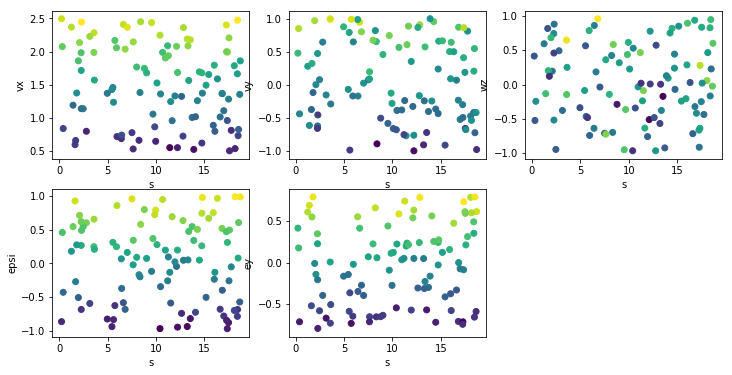

In [23]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])

for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[::10,4], zs[::10,ind], c=ys[::10,ind])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [24]:
if True:
    best_clustering = pwac.ClusterPWA.from_num_clusters(zs, ys, 10, z_cutoff=n, affine=affine, sparse_mask=sparse_mask)
    best_clustering.fit_clusters(verbose=True)
else:
    nc_list = [1,4,6,10]
    best_clustering, ind_perm = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n, affine=True)


assigning datapoints to clusters
updating models
centroid movement 3.70735885403
assigning datapoints to clusters
updating models
centroid movement 1.04861324796
assigning datapoints to clusters
updating models
centroid movement 0.589512478662
assigning datapoints to clusters
updating models
centroid movement 0.391642374933
assigning datapoints to clusters
updating models
centroid movement 0.237956686371
assigning datapoints to clusters
updating models
centroid movement 0.192769675105
assigning datapoints to clusters
updating models
centroid movement 0.329219974655
assigning datapoints to clusters
updating models
centroid movement 0.224755412888
assigning datapoints to clusters
updating models
centroid movement 0.180735450462
assigning datapoints to clusters
updating models
centroid movement 0.151391137407
assigning datapoints to clusters
updating models
centroid movement 0.147414685346
assigning datapoints to clusters
updating models
centroid movement 0.147819223081
assigning datapoin

In [25]:
best_clustering.Nc

10

In [26]:
pwac.print_PWA_models(pwac.get_PWA_models(best_clustering.thetas, n, d))

[[ 0.97 -0.02  0.04  0.    0.    0.     nan  0.    0.08   nan  0.08]
 [ 0.    0.26 -0.03  0.    0.    0.     nan  0.23  0.     nan  0.  ]
 [-0.    0.18  0.1   0.    0.    0.     nan  4.06  0.     nan  0.  ]
 [ 0.01 -0.01  0.06  1.03 -0.06 -0.03   nan  0.    0.     nan  0.  ]
 [ 0.08 -0.   -0.   -0.01  1.01  0.04   nan  0.    0.     nan  0.  ]
 [-0.    0.04 -0.01  0.14 -0.    0.99   nan  0.    0.     nan  0.  ]]
[[ 0.96  0.   -0.03  0.    0.    0.     nan  0.    0.07   nan  0.07]
 [-0.01  0.16 -0.01  0.    0.    0.     nan  0.23  0.     nan  0.  ]
 [-0.01  0.07  0.13  0.    0.    0.     nan  2.74  0.     nan  0.  ]
 [-0.04  0.01  0.04  0.98 -0.   -0.02   nan  0.    0.     nan  0.  ]
 [ 0.11 -0.01  0.   -0.01  1.    0.05   nan  0.    0.     nan  0.  ]
 [ 0.01  0.03 -0.    0.07 -0.    1.01   nan  0.    0.     nan  0.  ]]
[[ 0.97 -0.05 -0.02  0.    0.    0.     nan  0.    0.13   nan  0.13]
 [-0.    0.33 -0.06  0.    0.    0.     nan  0.15  0.     nan  0.  ]
 [-0.02  0.17  0.27  0.    0.   

In [27]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 144000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 9070, constraints m = 18000
Cones:	linear vars: 18000
Setup time: 5.47e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.69e+00  8.19e+00  9.85e-01 -2.36e+01  4.43e+01  0.00e+00  3.49e-02 
   100| 1.66e-01  2.44e-01  4.38e-02  4.74e+00  5.22e+00  1.85e-15  1.54e+00 
   200| 7.50e-02  1.67e-01  9.32e-02  1.03e+00  1.35e+00  1.62e-15  2.76e+00 
   300| 3.85e-02  1.40e-01  6.37e-02  6.24e-01  7.76e-

In [28]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_'+trackname+'_'+str(best_clustering.Nc), labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=best_clustering.zs, ys=best_clustering.ys)

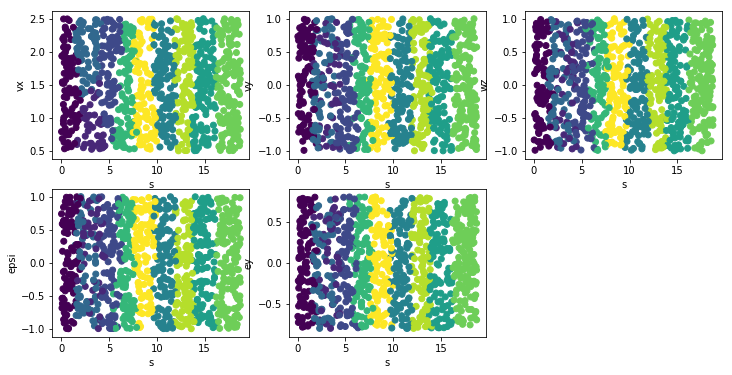

In [29]:
data = np.load('pwa_model_oval_10.npz')
# looks like everything is in the same region here....

labels = []
for z,y in zip(zs,ys):
    dot_pdt = [w.T.dot(np.hstack([z[0:n], [1]])) for w in data['region_fns']]
    labels.append(np.argmax(dot_pdt))

plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']

In [16]:
pwac.getRegionMatrices(best_clustering.region_fns)

([array([[   5.50037982,   -1.90882199,   -3.16823685,    5.56403496,
           177.34394541,   -0.64033323],
         [   4.37602257,   -0.48930028,   -0.24263818,   -0.54014911,
           112.728199  ,   -2.77096829],
         [   9.10025457,   -2.0120832 ,   -0.92961137,   -1.83368628,
            73.62091953,    0.94754071],
         [   2.60589791,   -2.64912587,    2.43539486,   -2.14209825,
            38.79762424,    1.97082554]]),
  array([[ -5.50037982e+00,   1.90882199e+00,   3.16823685e+00,
           -5.56403496e+00,  -1.77343945e+02,   6.40333234e-01],
         [ -1.12435725e+00,   1.41952171e+00,   2.92559867e+00,
           -6.10418407e+00,  -6.46157464e+01,  -2.13063506e+00],
         [  3.59987475e+00,  -1.03261214e-01,   2.23862548e+00,
           -7.39772124e+00,  -1.03723026e+02,   1.58787395e+00],
         [ -2.89448191e+00,  -7.40303885e-01,   5.60363170e+00,
           -7.70613321e+00,  -1.38546321e+02,   2.61115878e+00]]),
  array([[  -4.37602257,    0.489300

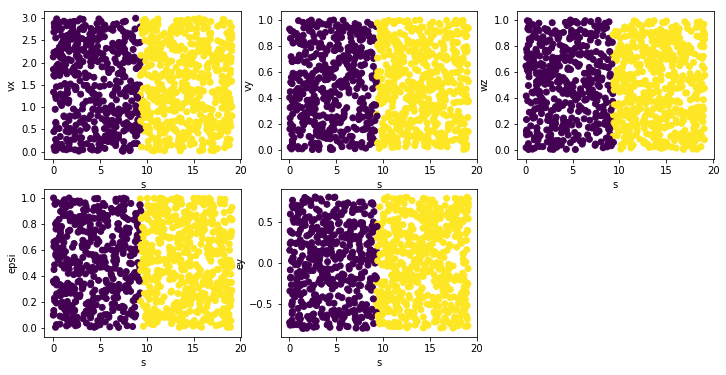

In [17]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=best_clustering.cluster_labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

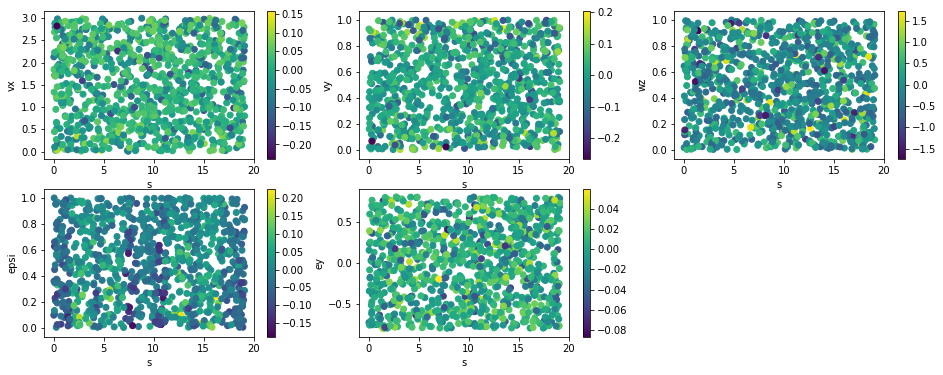

In [18]:
yhats = []
for z,y in zip(best_clustering.zs, best_clustering.ys):
    yhats.append(best_clustering.get_prediction(z))
yhats = np.array(yhats)

plt.figure(figsize=[16,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=(best_clustering.ys[:,ind]-yhats[:,ind]))
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind]); plt.colorbar()

In [9]:
best_clustering.Nc

15

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]


In [ ]:
# 10 regions (fit from sim)
[[ 0.99 -0.04 -0.03  0.02  0.    0.03   nan  0.21  0.11   nan -0.  ]
 [ 0.08  0.26 -0.03 -0.05  0.   -0.02   nan  0.24  0.02   nan -0.08]
 [-0.11  0.73 -0.05 -0.28  0.    0.31   nan  2.93  0.13   nan  0.04]
 [ 0.02  0.03  0.02  1.   -0.   -0.03   nan  0.16  0.02   nan  0.  ]
 [ 0.08  0.02 -0.   -0.07  1.   -0.03   nan  0.01 -0.     nan  0.02]
 [ 0.06  0.02 -0.    0.09  0.    0.99   nan  0.03  0.02   nan -0.05]]

In [ ]:
# 2 regions (fit from sim)
[[ 0.98  0.03 -0.01  0.01  0.    0.     nan  0.07  0.1    nan -0.01]
 [ 0.06  0.22 -0.02 -0.03  0.    0.     nan  0.23  0.02   nan -0.05]
 [ 0.05  0.28  0.01 -0.02  0.    0.04   nan  2.73  0.04   nan -0.07]
 [ 0.03  0.01  0.02  1.01  0.   -0.02   nan  0.18  0.     nan  0.  ]
 [ 0.08 -0.    0.   -0.06  1.   -0.03   nan -0.01 -0.     nan  0.02]
 [ 0.05  0.03 -0.    0.08  0.    1.     nan  0.03  0.01   nan -0.04]]
[[ 0.98  0.02 -0.01 -0.   -0.   -0.     nan  0.15  0.1    nan  0.  ]
 [ 0.06  0.24 -0.04 -0.03 -0.    0.01   nan  0.18  0.01   nan -0.05]
 [ 0.07  0.1   0.07  0.07  0.01  0.08   nan  3.32  0.01   nan -0.04]
 [ 0.03  0.01  0.03  1.    0.   -0.02   nan  0.2   0.     nan  0.  ]
 [ 0.09 -0.01  0.01 -0.06  1.   -0.04   nan -0.01  0.     nan  0.02]
 [ 0.05  0.04 -0.    0.08 -0.    1.     nan  0.03  0.     nan -0.04]]


In [ ]:
# 2 (1) regions (fit from trajectory)
[[ 0.95  0.53 -0.05 -0.01 -0.    0.03   nan  0.01  0.09   nan  0.01]
 [-0.01 -0.    0.01 -0.    0.   -0.01   nan  0.25 -0.     nan  0.01]
 [-0.19 -0.94  0.15 -0.02  0.   -0.08   nan  2.41 -0.03   nan  0.12]
 [ 0.02  0.01  0.02  1.09 -0.    0.02   nan  0.18  0.01   nan  0.  ]
 [ 0.09 -0.02  0.   -0.01  1.   -0.02   nan -0.    0.     nan  0.  ]
 [ 0.01 -0.03  0.01  0.07  0.    1.     nan  0.02  0.     nan -0.  ]]
[[ 0.83  0.39 -0.05  0.02 -0.   -0.05   nan  0.04  0.09   nan  0.12]
 [-0.01 -0.12  0.02  0.   -0.   -0.     nan  0.25 -0.     nan  0.01]
 [-0.21 -2.13  0.27  0.03 -0.   -0.04   nan  2.43 -0.     nan  0.14]
 [ 0.01 -0.22  0.05  1.1  -0.    0.01   nan  0.18 -0.     nan  0.01]
 [ 0.08  0.03 -0.   -0.    1.   -0.03   nan  0.    0.     nan  0.01]
 [ 0.    0.01  0.    0.07 -0.    1.     nan  0.02  0.     nan -0.  ]]


In [26]:
best_clustering.h

AttributeError: 'ClusterPWA' object has no attribute 'h'

In [27]:
min([])

ValueError: min() arg is an empty sequence